# Imports

In [ ]:

!git clone https://github.com/SAIDBELAKBIR37/Tensorflow-corrosion-detection-

fatal: destination path 'CorrosionDetector' already exists and is not an empty directory.


In [ ]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
!pip uninstall tensorflow
!pip install tensorflow==1.15


import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image
#!pip install tensorflow-object-detection-api
sys.path.append("..")
#from object_detection.utils import ops as utils_ops

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import sklearn.metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import seaborn
import numpy as np
import os
cwd = os.getcwd()
from PIL import Image
import time
import copy
import random
import cv2
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print(tf.__version__)

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
    /usr/local/lib/python3.7/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0
  Using cached https://files.pythonhosted.org/packages/92/2b/e3af15221da9ff323521565fa3324b0d7c7c5b1d7a8ca66984c8d59cb0ce/tensorflow-1.15.0-cp37-cp37m-manylinux2010_x86_64.whl
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.0 which is incompatible.


1.15.0


## Env setup

In [ ]:

print(tf.__version__)

1.15.0


In [ ]:
%matplotlib inline

In [ ]:
!pip install tensorflow-object-detection-api

     |████████████████████████████████| 583kB 12.7MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 3.2MB 25.7MB/s 
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detection_api-0.1.1-cp37-none-any.whl size=844515 sha256=08cd7686df2cf56673e3ffb0fdcacc26e66df91c89d64d5c0b09c086a61c0282
  Stored in directory: /root/.cache/pip/wheels/4a/54/d0/cfca11930c4b2025d40dede77059094070a67cc3e7bd3b285f
Successfully built tensorflow-object-detection-api


# Model preparation 

In [ ]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

In [ ]:
PATH_TO_CKPT = 'CorrosionDetector/frozen_inference_graph.pb' #change this path as in your system

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('CorrosionDetector', 'rust_label_map.pbtxt')

NUM_CLASSES = 1

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map 

In [ ]:

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [ ]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [ ]:
PATH_TO_TEST_IMAGES_DIR = '/content/test' # check this path, and provide the image file names properly

TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'rust.{}.jpg'.format(i)) for i in (7,13,12) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
%matplotlib inline

In [ ]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

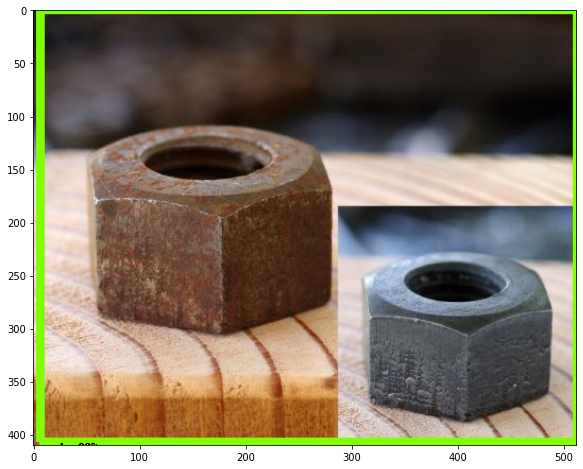

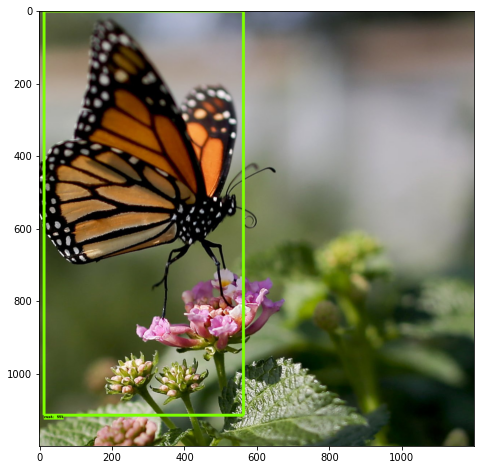

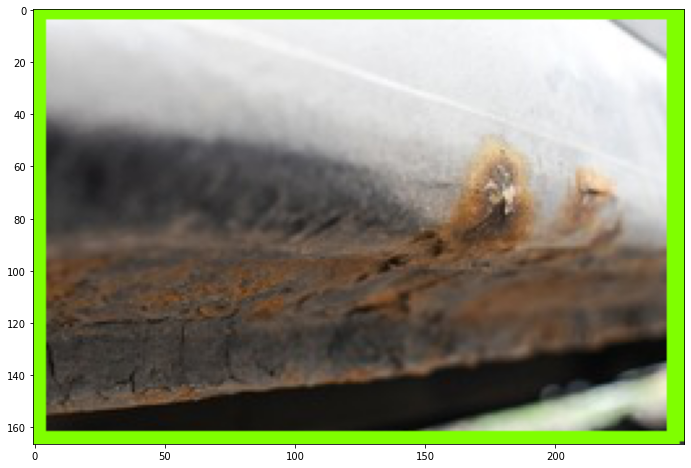

In [ ]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

WEBCAM 

In [ ]:

cap = cv2.VideoCapture(0)   # if you have multiple webcams change the value to the correct one




with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        while True:
            ret, image_np = cap.read()
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=8)

            cv2.imshow('object detection', cv2.resize(image_np, (800, 600)))
            if cv2.waitKey(25) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
                break